In [1]:
#### main.ipynb
import numpy as np
from setup_functions.run_training import run_training
import torch
import warnings

# Vensim model and parameters
"""
dictionary that holds inputs about the vensim simulation model
"""

vensimInputs={
    'venModelName': 'RandomWalk3', # name of the vensim model (should be .vmpx for dll, and .mdlx for script-based)
    'venVOCFile' : 'RandomWalk3.voc',  # A .voc or .out file from whichc estimated parameter names and ranges can be read (must include upper and lower bounds)
    'outputs': ['State Obs'], # vensim output variables to be recorded and trained on
    'constant_vals' : [99],  # Values of constants to be set for all simulations in a context
    'Time_points' : np.arange(100), # All times for which data points should be extracted; should be consistent with Final Time- Start Time
    'feature_names' : ["State Observed"], # names of features in time series
    'ylabels' : ['Dimensionless'], # label for each feature of time series
    'true_parameter_file' : None,
    'num_true_parameters' : 500,

    # 'venModelName': 'SEIRbNosubs',
    # 'venVOCFile': 'SEIRb.voc',
    # 'outputs': ['Simulated Onset Data','Simulated Recovery Data','Simulated Death Rate Data'],
    # 'constant_vals' : [299],
    # 'Time_points' : np.arange(300),
    # 'feature_names' : ["Onset", "Recovery", "Death Rate"],
    # 'ylabels' : ["People/Day", "People/Day", "People/Day"],
    # 'true_parameter_file' : 'SEIRb_true_params_tensor.py',
    # 'num_true_parameters' : 500,
    
    # 'venModelName': 'MarketGrowth',
    # 'venVOCFile': 'MarketGrowth.voc',
    # 'outputs': ['MN1', 'MN2', 'MN3', 'MN4'],
    # 'constant_vals' : [129],
    # 'Time_points' : np.arange(130),
    # 'feature_names' : ["Capacity", "Order Rate", "Sales Force", "Revenue"],
    # 'ylabels' : ["Units/Month", "Units/Month", "People", "$/Month"],
    # 'true_parameter_file' : 'MG_true_params_tensor.py',
    # 'num_true_parameters' : 500,

    # 'venModelName': 'LotkaVoltera-Extended',
    # 'venVOCFile': 'LotkaVoltera-Extended.voc',
    # 'outputs': ['MN1', 'MN2'],
    # 'constant_vals' : [199],
    # 'Time_points' : np.arange(200),
    # 'feature_names' : ["N1", "N2"],
    # 'ylabels' : ["Units", "Units"],
    # 'true_parameter_file' : None,
    # 'num_true_parameters' : 500,

    # 'venModelName': 'GeneralizedBass',
    # 'venVOCFile': 'GeneralizedBass.voc',
    # 'outputs': ['MN1', 'MN2'],
    # 'constant_vals' : [299],
    # 'Time_points' : np.arange(300),
    # 'feature_names' : ["Adopters", "Adoption Rate"],
    # 'ylabels' : ["People", "People/Month"],
    # 'true_parameter_file' : None,
    # 'num_true_parameters' : 500,

    # 'venModelName': 'RBC',
    # 'venVOCFile': 'RBC.voc',
    # 'outputs': ['MN1', 'MN2'],
    # 'constant_vals' : [99],
    # 'Time_points' : np.arange(100),
    # 'feature_names' : ["Output", "Capital"],
    # 'ylabels' : ["$/Year", "$"],
    # 'true_parameter_file' : None,
    # 'num_true_parameters' : 500,

    # 'venModelName': 'WorldDynamics',
    # 'venVOCFile': 'WorldDynamics.voc',
    # 'outputs': ['MN1','MN2','MN3', 'MN4', 'MN5'],
    # 'constant_vals' : [199],
    # 'Time_points' : np.arange(200),
    # 'feature_names' : ["Population", "Capital Investment", "Natural Resources", "Pollution", "Food Ratio"],
    # 'ylabels' : ["People", "Capital", "Acre", "Pollution", "Dimensionless"],
    # 'true_parameter_file' : None,
    # 'num_true_parameters' : 500,
    
    'SeedVar' : 'NSeed', # Name of the variable in vensim that controls the noise seed; default is 'NSeed'
    'constants' : ['Final Time'], # Name of constants to be set before start of the simulations
    'useDll' : True, # Using DLL (venpy) or script based (VST) connection with Vensim
    'use_ven_multi' : True, # whether to use multicore or single core vensim
    'vengine_path': "C:/Program Files/Vensim/vendss64MC.exe",  # Change this to your Vengine file path!
    'vensim_path': "C:/Program Files/Vensim/vendss64.exe",  # Change this to your Vensim file path!
    'manual_summaries': True,
    'plot': False,
    # summary stats
    'num_moments' : 2, # number of moments of data
    'num_points' : 20, # number of data points in time series to record
    'lags' : [0, 5, 10], # number of lags to calculate covariances 
    'window_length': 20, # window length for savitzky filter
    'polyorder' : 2, # polynomial order for savitzky filter
}

#other keys to be created:
"""
device: cpu or gpu, used to move tensors to correct device
venParameters: names of dimensions
manual_dimensions: number of manual summary statistics; used to split tensor in sequence network
x_o: simulation tensor, used to set the size of the initial input channels in SBI_Inputs
"""

"""
dictionary that holds inputs for embedding networks, SBI inference network, and SBI trainers 
"""

SBI_Inputs={
    # Sequence network settings
    'summary_dim' : 20, # should be 4 times the number of dimensions (parameters)
    'num_conv_layers' : 4,
    'lstm_units' : 128,
    'bidirectional' : True,
    'out_channels' : 32,
    'min_kernel_size' : 1,
    'max_kernel_size' : 3,
    # Training settings
    'training_batch_size' : 32, # 64 for testing, 32 for actual results
    'stop_after_epochs' : 20,
    'learning_rate' : 0.0010,
    'show_train_summary' : True,
    
    # Data settings
    'num_rounds' : 1, # number of training rounds
    'amortized' : True, # whether the round-based training is ammortized or sequential
    'save_density_estimator' : False, # option to save trained estimator
    'load_density_estimator' : True, # Loading from the already saved density estimator 
    'sampleSize' : 100, # number of samples for training, SINGLE RUN 8192
    'multiple_sample_sizes': [1000, 10000, 100000], # number of samples for training, MULTIPLE RUNS for validation
    'valid_size': 500, # size of validation dataset for generating posterior #what will happen if we have 100 true params but this is 500
    
    # this should be high values to make things statistically significant
    'post_samples_per_obs': 10_000, # samples drawn per observation # ali: we should add proper comments to tell where it's being used (like: used for calculating the scalar metrics)
    
    'force_first_round_loss' : False, # uses the same loss function that's used in the first round (MLE)
    'use_combined_loss' : False,
    'discard_prior_samples' : False,
    'retrain_from_scratch' : False,
    'sample_with' : 'direct', # method of sampling from posterior, default 'direct'
    # Inference settings
    'model' : 'maf',
    # maf arguments
    'hidden_features' : 50, # number of hidden features in
    'num_transforms' : 6, # number of transforms
    'num_blocks' : 2, # number of blocks used for residual net for context embedding
    'dropout_probability' : 0.0, # dropout probability for regularization in residual net
    'use_batch_norm' : False # whether to use batch norm in residual net
}


"""
dictionary that holds inputs relevant to graphing the experiment results
"""
resInputs={
    'scenario_name' : 'RW_1r_NPE', # scenario name used for saving graphs
    'graph_yaxis' : 'Random Walk', # label for y-axis of validation metrics
    'show_graphs' : True, # whether to display the diagnostic graphs 
    'save_graphs' : True, # whether to save graphs as jpeg
    'recovery_percentile' : 80, # percentiles for recovery plots
    'rcvr_prcnl': 80,
    'graph_diagnostics': True, # graph posterior, ground truth recovery, z_score, confidence
    'pairplot_sample_size': 10_000, # sample size for graphing the posterior
    'calculate_validation_metrics': True, # calculate RMSE, agg. posterior constraction, agg. interval score
    'credible_levels': [0.50, 0.75, 0.95], # credible levels to compute coverage
    #'credible_levels': [0.1, 0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 0.95], # credible levels to compute coverage
    'rounds_to_plot_post' : [], # rounds to plot the posterior, if desired (enter round-1)
    'save_pickle': False,
}

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


running amortized


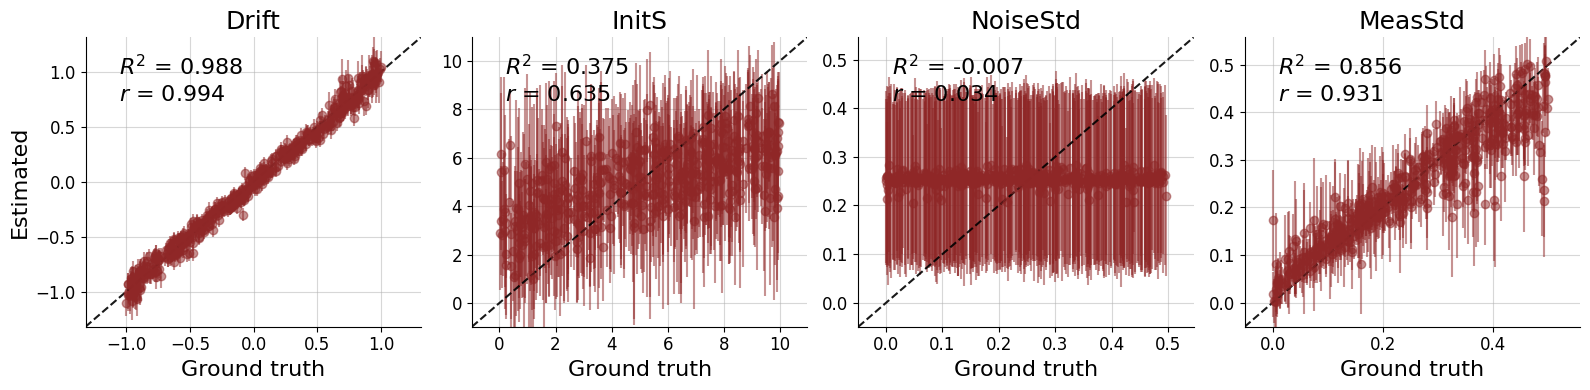

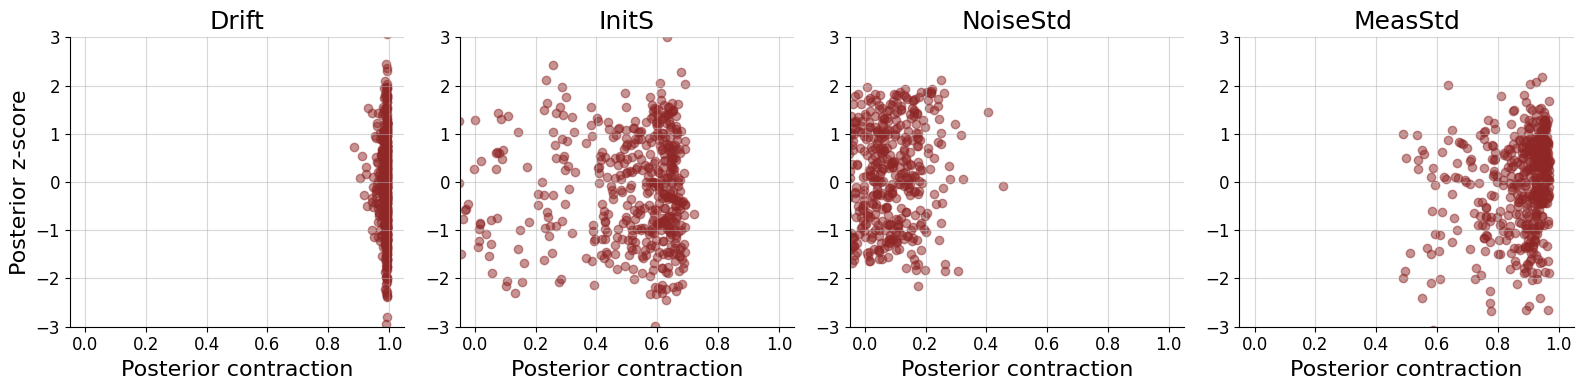

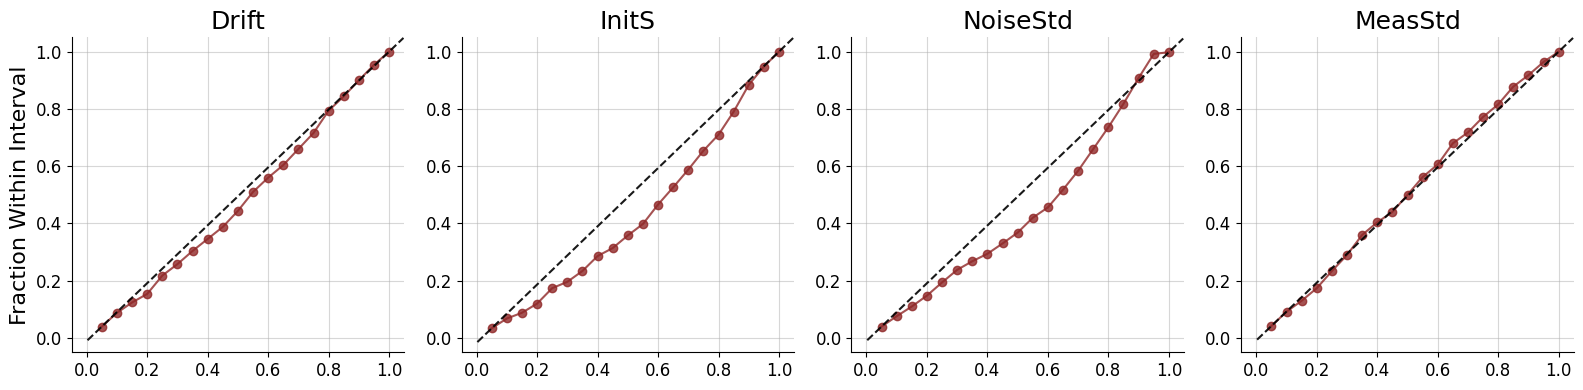

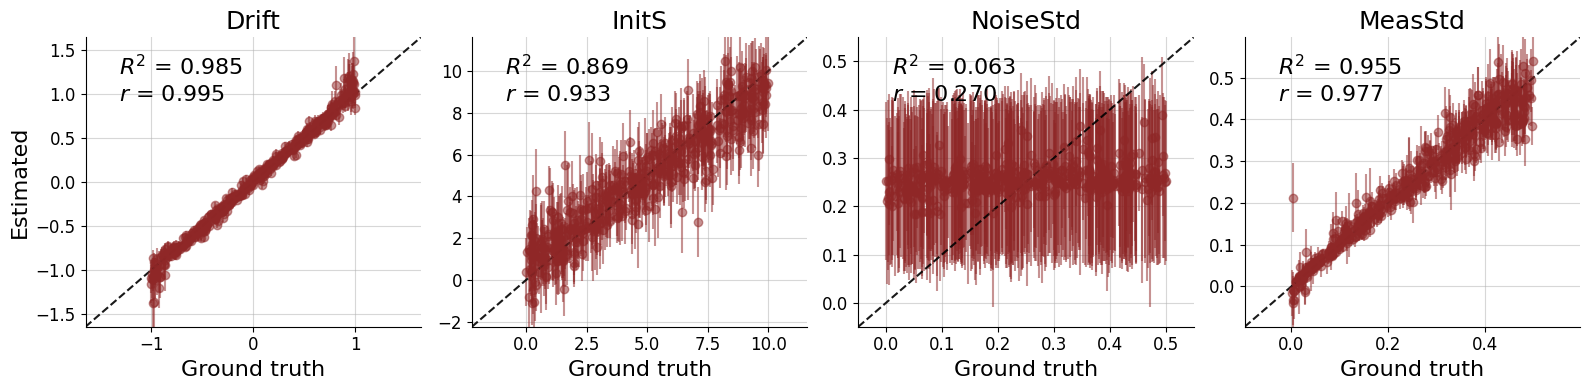

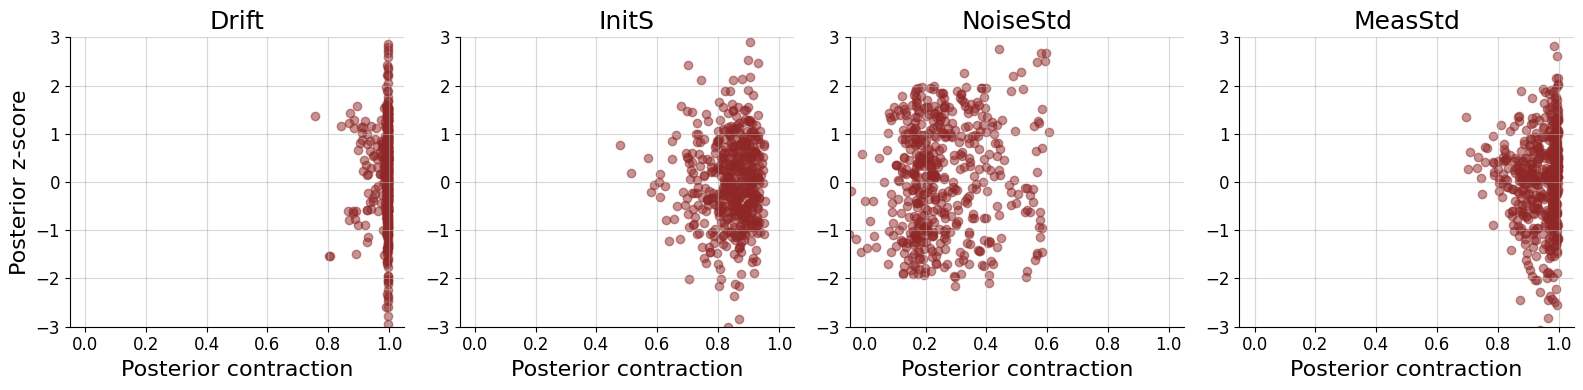

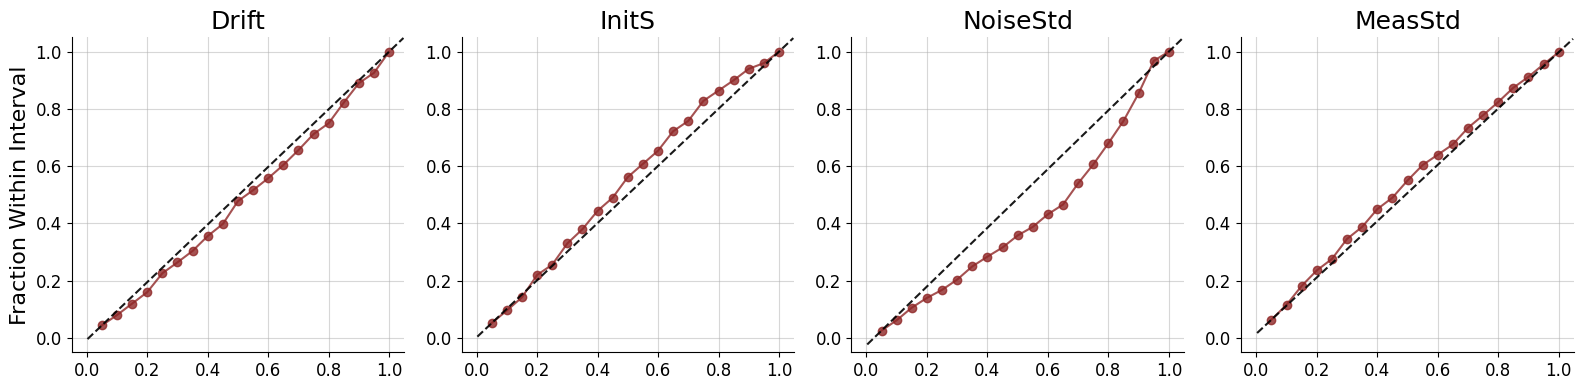

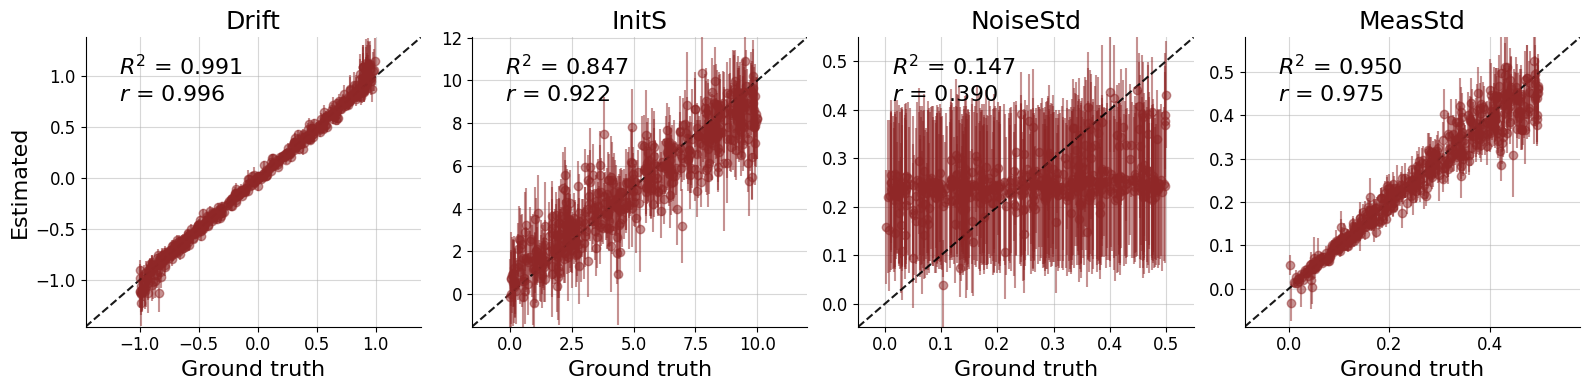

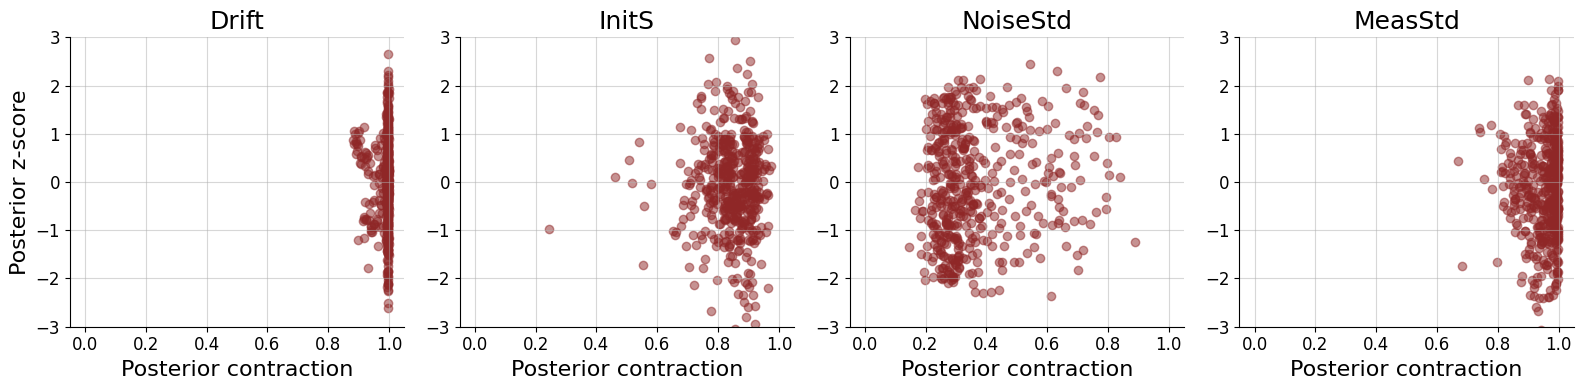

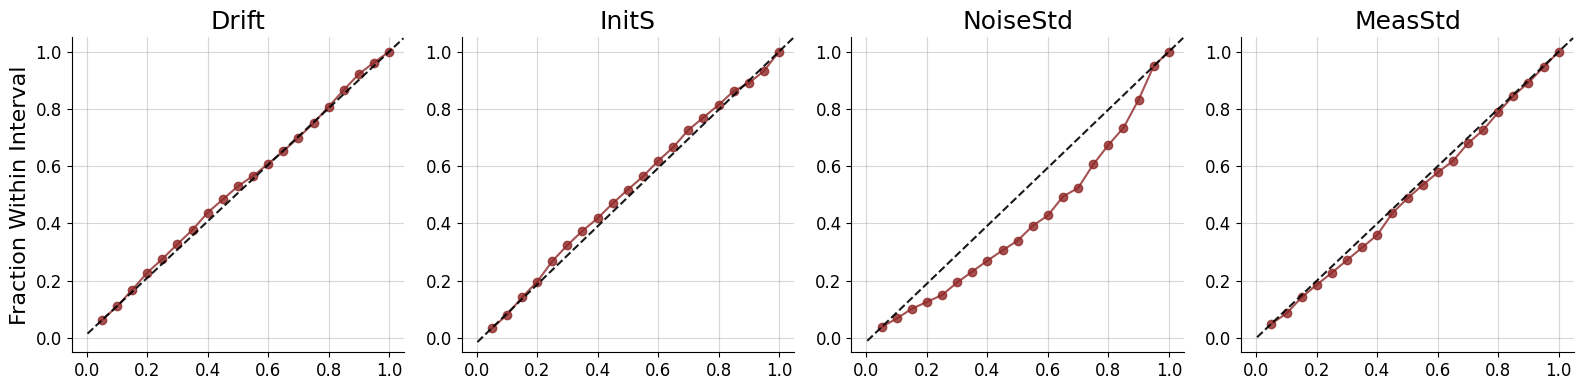

valid_calc: {'rmse': array([0.68256503, 0.49881789, 0.49526677]), 'agg_post_cont': array([0.60342962, 0.76034999, 0.78570384]), 'agg_int_score': array([2.21020699, 1.64531839, 1.61437857]), 'coverage_probabilities': {0.5: array([0.0825, 0.013 , 0.031 ]), 0.75: array([0.0495, 0.019 , 0.037 ]), 0.95: array([0.0145, 0.0025, 0.0025])}, 'overall_coverage': array([0.04883333, 0.0115    , 0.0235    ]), 'agg_z_score': array([-0.04365237,  0.06952544, -0.07703714]), 'z_score_std': array([1.04020214, 1.0271914 , 1.03412914]), 'sbc_ks_pvals': array([], dtype=float64)}


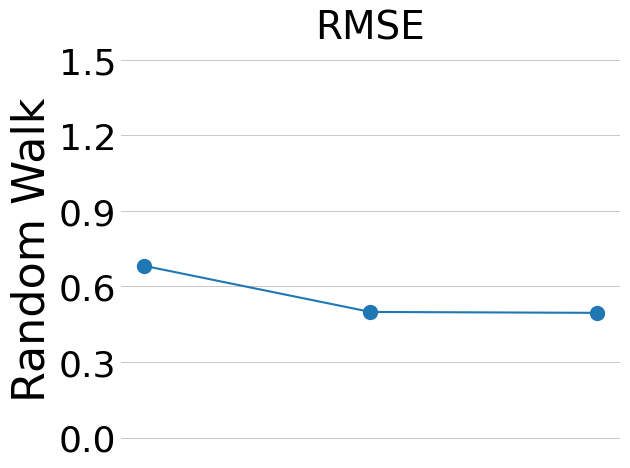

[0.68, 0.5, 0.5]


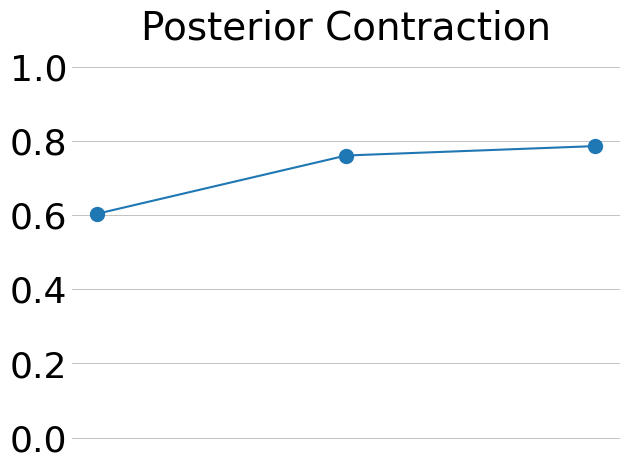

[0.6, 0.76, 0.79]


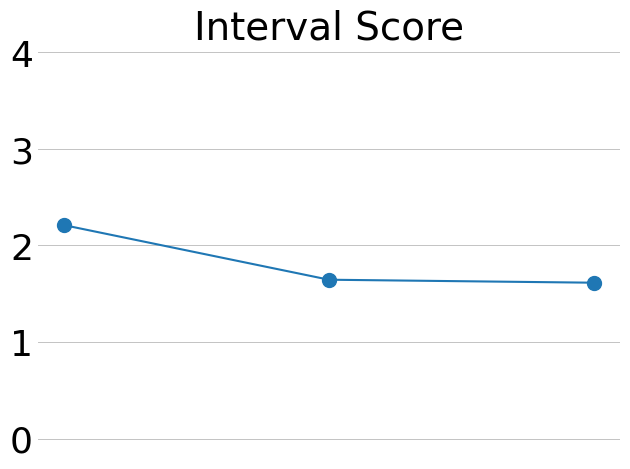

[2.21, 1.65, 1.61]


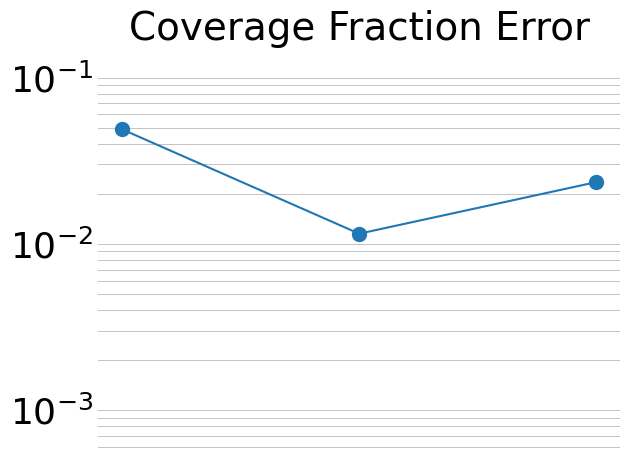

[0.05, 0.01, 0.02]


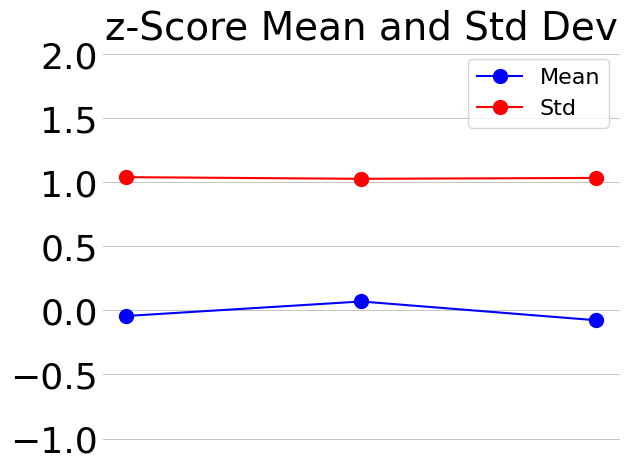

z-Score Mean: [-0.04, 0.07, -0.08]
z-Score Std: [1.04, 1.03, 1.03]


In [2]:
np.random.seed(42)
torch.manual_seed(42)
warnings.filterwarnings("ignore", category=UserWarning)
vensimInputs['device'] = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

posterior = run_training(vensimInputs, SBI_Inputs, resInputs) 